In [12]:
import pandas as pd
from pathlib import Path
from Bio import SeqIO
import seaborn as sns
from dna_features_viewer import GraphicFeature, GraphicRecord

Functions for reading sequence data

In [2]:
def recursive_seq_read(path):
    for thing in Path(path).iterdir():
        if thing.is_dir():
            recursive_seq_read(thing)
        else:
            try:
                yield seq_read(thing)
            except ValueError:
                # print(f'Could not read {thing}')
                pass
            
def seq_read(filepath):
    common_suffi = {
        '.fa': 'fasta'
    }
    fp = Path(filepath)
    if fp.suffix in common_suffi:
        record_format = common_suffi[fp.suffix]
    else:
        record_format = fp.suffix[1:]  # use file suffix without . for type
    
    return SeqIO.parse(str(fp), record_format)  

Read Albert's predictions.

In [3]:
NEG_PRED_PATH = 'albertPredict/negative_predictions_ethan.csv'
POS_PRED_PATH = 'albertPredict/positive_predictions_ethan.csv'

In [4]:
pos_strand_pred, neg_strand_pred = pd.read_csv(POS_PRED_PATH), pd.read_csv(NEG_PRED_PATH)

## T7 initiation series predictions

Pull out T7 initiation series rows.

In [5]:
def get_t7_init_pred(df):
    return df[df['name'].str.contains('T7_init')]

t7_init_pos = get_t7_init_pred(pos_strand_pred)
t7_init_pos

,name,cluster,0,1,2,3,4,5,6,7,...,3029,3030,3031,3032,3033,3034,3035,3036,3037,3038


Hmm, maybe there are missing sequences?

In [6]:
print(pos_strand_pred.shape)
print(neg_strand_pred.shape)

(961, 3041)
(961, 3041)


Check number of sequences in the substrate file I sent.

In [7]:
len(list(seq_read('prediction_substrates_2021-11-14.fa')))

994

In [8]:
994-961

33

Does look like some are missing, maybe not included becuase these are different in length?

## T7 termination series

### Where is probibility density in general along sequences?

First need to re-annotate fasta files with locations of important stuff, namely initiating insert, terminating insert.

Initiation region starts 28 bp from start of sequence and ends at 228. Termination region starts 10 bp downstream (238 from start) and ends 200 bp away from that 438 from start. This is the same for all plasmids.

#### Make locations into features for plotting

In [40]:
general_term_feats=[
    GraphicFeature(start=28, end=228, strand=+1, color="#ffd700",
                   label="Init insert"),
    GraphicFeature(start=238, end=438, strand=-1, color="#ffcccc",
                   label="Term insert"),
    GraphicFeature(start=238+1057, end=238+1894, strand=-1, color='#cffccc',
                  label="AMP")
]

basic_term_map = GraphicRecord(sequence_length=pos_strand_pred.shape[-1], features=general_term_feats)

(<AxesSubplot:>,
 ({GF(Init insert, 28-228 (1)): 0,
   GF(Term insert, 238-438 (-1)): 0,
   GF(AMP, 1295-2132 (-1)): 0},
  {GF(Init insert, 28-228 (1)): {'feature_y': 0, 'annotation_y': 2.0},
   GF(Term insert, 238-438 (-1)): {'feature_y': 0, 'annotation_y': 1.0}}))

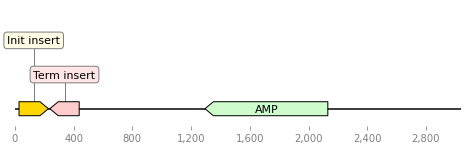

In [41]:
basic_term_map.plot(figure_width=8)

In [70]:
import matplotlib.pyplot as plt
import numpy as np

In [88]:
def cluster_average_over_plasmid_plot(graphicPlasmid, df):
    # melt df to long
    df_liquid = pd.melt(
        df, id_vars=['name', 'cluster'], var_name='index', 
        value_name='prob'
    )
    # get number of clusters
    num_clust = df_liquid['cluster'].max()+1
    fig, subs = plt.subplots(
        num_clust+1, 1, figsize=(12, 8), sharex=True
    )
    
    pal = sns.color_palette("Dark2")
    pal_hex = pal.as_hex()
    
    for i in range(num_clust):
        print(f'Plotting cluster {i}')
        clust_values = df_liquid.loc[df_liquid['cluster'] == i]
        print(clust_values.shape)
        print(pal_hex[i])
        sns.lineplot(
            ax=subs[i+1], data=clust_values, x='index', 
            y='prob', color=pal_hex[i])
        # set x ticks so not crazy dense
        #subs[i+1].set_xticks(np.arange(0, clust_values.shape[-1]-1, 250))
        subs[i+1].set(title=f'Cluster {i}')
    
    # plot plasmid map
    basic_term_map.plot(ax=subs[0], with_ruler=False)
    fig.tight_layout(pad=2.0)
    
    return fig, subs

In [ ]:
cluster_average_over_plasmid_plot(basic_term_map, pos_strand_pred)

Plotting cluster 0
(522708, 4)
#1b9e77
Plotting cluster 1
(820530, 4)
#d95f02
Plotting cluster 2
(419382, 4)
#7570b3
Plotting cluster 3
(501435, 4)
#e7298a
Plotting cluster 4
(656424, 4)
#66a61e


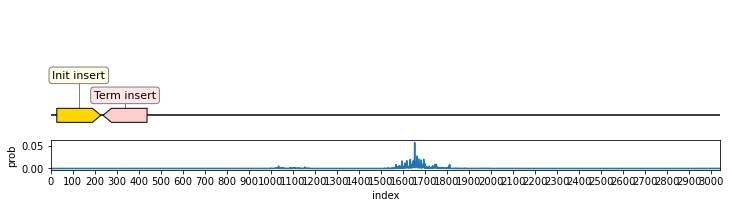

In [34]:
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(12, 3), sharex=True, gridspec_kw={"height_ratios": [4, 1]}
)

basic_term_map.plot(ax=ax1, with_ruler=False)
ax2 = sns.lineplot(data=clust_0, x='index', y='prob')
ax2.set_xticks(np.arange(0, pos_strand_pred.shape[-1]-1, 250))

In [59]:
pal = sns.color_palette("Dark2")
pal.as_hex()[0]

'#1b9e77'